# <center> CLASSIFICAÇÃO DE GRANITOS

In [61]:
#utilitários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

#Pré processamento
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split

#Modelos
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb


#Avaliadores
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import compute_sample_weight

#salvar e carregar modelos treinados
import joblib

#filtrando alertas
import warnings
warnings.filterwarnings("ignore")
xgb.set_config(verbosity=0)

#parâmetros para o matplotlib
plt.rcParams.update({'font.size': 14})

In [35]:
#funções usadas no notebook

def treino_de_classificadores(classificadores, X_treino, y_treino, pesos):
    for classificador in classificadores:
        classificador.fit(X_treino, np.ravel(y_treino), sample_weight=pesos)
        y_previsao = cross_val_predict(classificador, X_treino, y_treino, cv=10)
        precisao = precision_score(y_treino, y_previsao, average = 'macro')
        revocacao = recall_score(y_treino, y_previsao, average = 'macro')
        pontuacao_f1 = f1_score(y_treino, y_previsao, average = 'macro')
        print(classificador.__class__.__name__)
        print(f'precisão:{precisao}, revocação:{revocacao}, F1 score: {pontuacao_f1}')
        
def teste_de_modelos(modelos, X_teste, y_teste):
    for modelo in modelos:
        previsoes_teste = modelo.predict(X_teste)
        print(modelo.__class__.__name__)
        print(classification_report(y_teste, previsoes_teste))
        print('_________________________________________________________________________________________________________')
        
def metricas_score(modelos, X_teste, y_teste):
    metricas_modelo = {}
    for indice, modelo in enumerate(modelos):
        nome = modelo.__class__.__name__
        previsao = modelo.predict(X_teste)
        f1 = f1_score(y_teste, previsao, average='macro')
        precisao = precision_score(y_teste, previsao, average='macro')
        acuracia = accuracy_score(y_teste, previsao)
        metricas_modelo[indice] = nome, f1, acuracia, precisao
        
    return pd.DataFrame.from_dict(metricas_modelo, orient='index', columns=['Modelo', 'F1', 'Acurácia', 'Precisão'])

## <center> CARREGANDO OS DADOS

In [3]:
#Carregando o database tratado
database = pd.read_csv('dataset/granitos_db_att.csv', sep = '\t', index_col = 0)

In [4]:
database = database[['SiO2', 'TiO2', 'Al2O3','FeOt', 'MnO', 'MgO', 'CaO', 'K2O', 'Na2O', 'Group']]
database_withoutNAN = database.dropna(subset=['MnO', 'TiO2','FeOt', 'MgO', 'Na2O', 'CaO', 'Al2O3'])
database_final = database_withoutNAN.query('SiO2 > 52 & SiO2 < 80').reset_index(drop=True)
database_final.shape

(3139, 10)

In [5]:
#Separando variáveis preditoras e variável alvo

database_preditores = database_final[['SiO2', 'TiO2', 'Al2O3','FeOt', 'MnO', 'MgO', 'CaO', 
                                'K2O', 'Na2O']]

database_alvo = database_final[['Group']]

In [6]:
#Repetição para calcular a soma de elementos maiores
database_preditores["soma"] = 0
for i in range(0,3139):
    database_preditores["soma"].loc[i] = database_preditores.iloc[i,].sum()

#Repetição para normalizar o total de elementos maiores para 100
for i in range(0, len(database_preditores)):
    for j in range(0, len(database_preditores.columns)):
        database_preditores.iloc[i,j] = ((database_preditores.iloc[i,j] * 100) / database_preditores.iloc[i]["soma"])

database_preditores.drop(labels='soma', axis=1)

,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,K2O,Na2O
0,65.595826,0.829426,17.134249,4.928605,0.077372,1.801216,1.818753,5.146773,2.667780
1,69.796557,0.710335,14.920101,4.195580,0.054092,1.632955,1.440062,5.029500,2.220819
2,70.750303,0.571713,15.314132,2.827681,0.053286,1.333257,1.206703,5.608338,2.334587
3,70.758884,0.478461,15.740098,2.513140,0.040742,0.979904,1.314200,5.291272,2.883300
4,70.869527,0.533421,15.315048,2.541511,0.060994,1.209900,1.238733,5.582618,2.648250
...,...,...,...,...,...,...,...,...,...
3134,66.558606,0.587580,15.297336,6.787560,0.020261,1.752609,2.968291,0.557188,5.470570
3135,59.406932,1.312362,15.728311,9.697455,0.120216,3.997195,4.007213,0.270487,5.459828
3136,66.913753,0.781328,15.326054,5.789843,0.050085,1.412401,2.794751,0.380647,6.551137
3137,72.219401,0.467242,12.290503,6.805485,0.020315,0.680549,2.133062,0.203149,5.180295


PRÉ PROCESSAMENTO

In [41]:
#Realizando um amostragem estratificada
X_train, X_test, y_train, y_test = train_test_split(database_preditores, database_alvo, test_size=0.30, stratify=database_alvo, random_state=42)

scaler = StandardScaler()
encoder = LabelEncoder()
X_train_scaled = scaler.fit_transform(X=X_train)
y_train_encoded = encoder.fit_transform(y_train)

# <center> TESTANDO OS MELHORES MODELOS

In [95]:
#post GridSearCV models

best_rnd_clf = RandomForestClassifier(bootstrap=False, max_features=3, criterion='entropy', n_estimators=100, random_state=42)
xgb_best = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.3,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.2, max_delta_step=0,
               max_depth=6, min_child_weight=1,
               monotone_constraints='()', n_estimators=100, n_jobs=8,
               num_parallel_tree=5, objective='multi:softprob', predictor='auto',
               random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1.5,
               subsample=0.9, tree_method='exact', validate_parameters=1,
               verbosity=None)

best_ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10, class_weight='balanced') ,algorithm='SAMME', n_estimators=100, learning_rate=0.75, random_state=42)

modelos = [best_rnd_clf, xgb_best, best_ada_clf]

In [96]:
#Treinando classificadores com pesos para as classes
pesos = compute_sample_weight("balanced", y_train)
treino_de_classificadores(modelos, X_train_scaled, y_train_encoded, pesos);

RandomForestClassifier
precisão:0.8739763331466709, revocação:0.8677953527305898, F1 score: 0.8706686475361755
XGBClassifier
precisão:0.8794463350987699, revocação:0.8690054558760106, F1 score: 0.8740026759886558
AdaBoostClassifier
precisão:0.8877234496313906, revocação:0.8780798715967576, F1 score: 0.8826251740169645


In [97]:
#scaling test variables
X_test_scaled = scaler.transform(X_test)
y_test_encoded = encoder.transform(y_test)

#testing models
metricas_modelos = metricas_score(modelos, X_test_scaled, y_test_encoded)

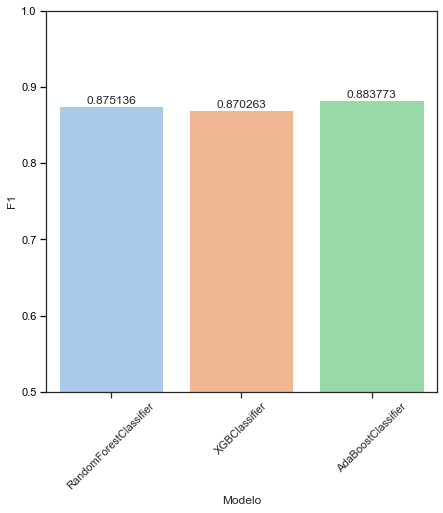

In [109]:
sns.set(style="ticks")
plt.figure(figsize = (7, 7))
plt.ylim(0.5, 1)
ax = sns.barplot(x=metricas_modelos['Modelo'], y=metricas_modelos['F1'], data=metricas_modelos, palette="pastel")
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation = 45)
ax.set_yticks([0.5,0.6,0.7,0.8,0.9,1])
ax.tick_params(axis='y', colors='black');
plt.savefig('Scores.jpg', dpi=600, format='jpg', bbox_inches = 'tight')

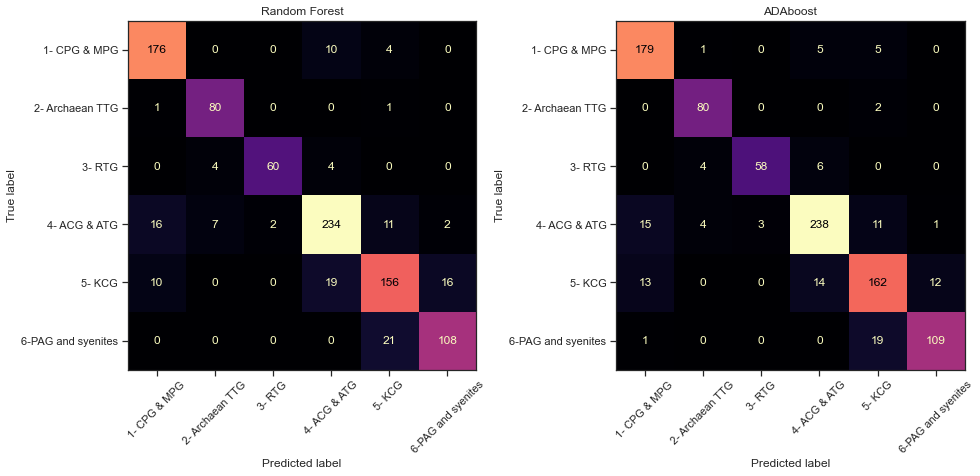

In [115]:
#predictions for test
random_forest_predictions = best_rnd_clf.predict(X_test_scaled)
ada_boost_predictions = best_ada_clf.predict(X_test_scaled)

#confusion matrix
conf_matrix1 = confusion_matrix(y_test_encoded, random_forest_predictions)
conf_matrix2 = confusion_matrix(y_test_encoded, ada_boost_predictions)

#Displaying confusion matrix for random forest test
fig, ax = plt.subplots(1,2,figsize=(15, 15))
ax[0].set_title("Random Forest")
ax[1].set_title("ADAboost")

cm = ConfusionMatrixDisplay(conf_matrix1,display_labels=encoder.classes_)
cm.plot(ax=ax[0], xticks_rotation=45,cmap='magma', colorbar=False)

#Displaying confusion matrix for adaboost test
cm = ConfusionMatrixDisplay(conf_matrix2,display_labels=encoder.classes_)
cm.plot(ax=ax[1], xticks_rotation=45,cmap='magma', colorbar=False)

plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

